# Neccessary Imports

In [22]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Set up GPU support

In [23]:
#gpu configuration
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using GPU:', torch.cuda.get_device_name())
else:
    device = torch.device("cpu")
    print('Using CPU')

Using GPU: Tesla T4


# Read datasets and create dataloaders

In [24]:
class MyDataset(Dataset):
    def __init__(self, filename):
        #Read CSV
        data = pd.read_csv(filename, header=None)
      
        #Split into features and labels 
        self.X = torch.tensor(data.iloc[:, :-1].values, dtype=torch.float32)
        self.y = torch.tensor(data.iloc[:, -1].values, dtype=torch.int8)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [25]:
classes = ["human","engine"]
#Load datasets
train_dataset = torch.load('train_dataset.pt')
test_dataset = torch.load('test_dataset.pt')

#Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#print the size of the training set
print("Number of Training Moves:", len(train_dataset))

#print the size of the testing set
print("Number of Testing Moves:", len(test_dataset))

Number of Training Moves: 10403
Number of Testing Moves: 1040


# Define the model

In [26]:
#Define neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5, 25)
        self.fc2 = nn.Linear(25, 50)  
        self.relu1 = nn.ReLU()
        self.fc3 = nn.Linear(50, 75)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(75, 100)
        self.relu3 = nn.ReLU()
        self.fc5 = nn.Linear(100, 150)
        self.relu4 = nn.ReLU()
        self.fc6 = nn.Linear(150, 2)         
        self.sigmoid = nn.Sigmoid()
        # Initialize the weights
        init.xavier_uniform_(self.fc1.weight)
        init.xavier_uniform_(self.fc2.weight)
        init.xavier_uniform_(self.fc3.weight)
        init.xavier_uniform_(self.fc4.weight)
        init.xavier_uniform_(self.fc5.weight)
        init.xavier_uniform_(self.fc6.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu2(x)
        x = self.fc4(x)
        x = self.relu3(x)
        x = self.fc5(x)
        x = self.relu4(x)
        x = self.fc6(x)
        x = self.sigmoid(x)
        return x 

# Define Learning Parameters

In [27]:
#Define learning parameters:
model = Net()
model = model.to(device)
loss_criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 50

# Training

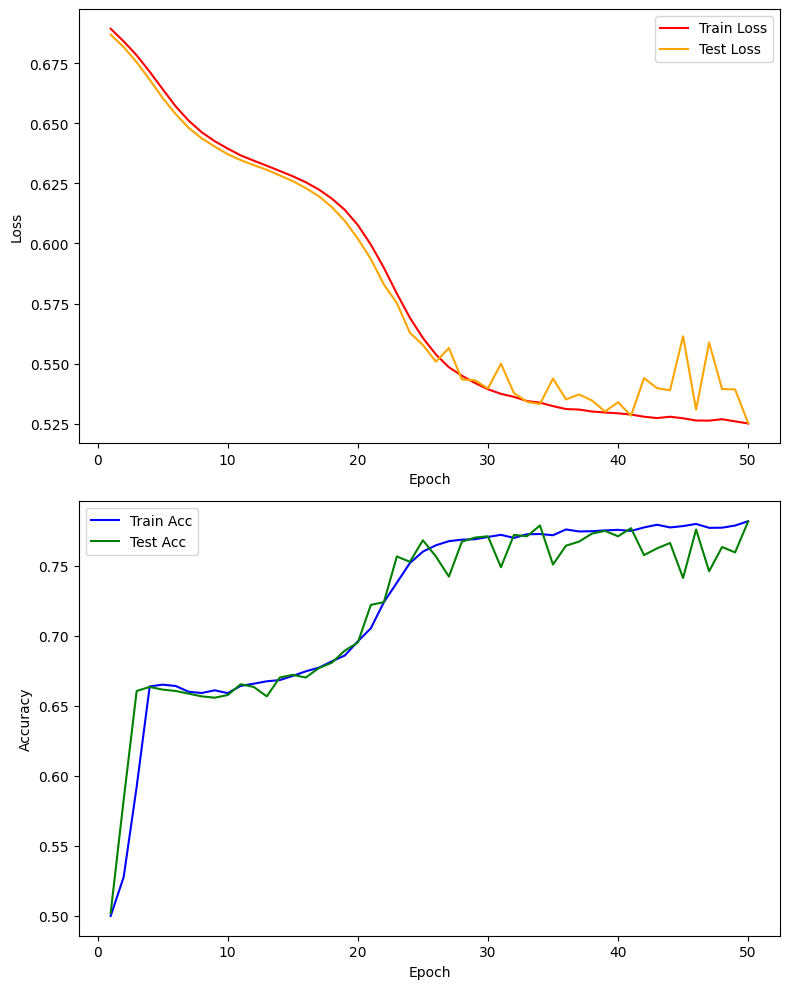

Finished Training


In [28]:
#Arrays for the graphs
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

#Training loop
for epoch in range(num_epochs):

    #For evaluation
    train_loss = 0.0
    train_correct = 0
    total = 0
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    #Model to training mode
    model.train()

    #Training loop
    for inputs, labels in train_loader:
        labels = labels.long()
        #Data to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)
        #Clear gradients
        optimizer.zero_grad()
        #Get loss and optimize
        outputs = model(inputs)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #Get training loss and accuracy
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        total += labels.size(0)

    #Get the training losses and accuracies to respective arrays
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = train_correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
 
    #Don't affect learning
    with torch.no_grad():
        for inputs, labels in test_loader:
            labels = labels.long()
            #Data to the GPU if available
            inputs = inputs.to(device)
            labels = labels.to(device)

            #Getting the loss
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)

            #Compute the test loss and accuracy
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

    #Get the test loss and accuracy
    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

#Graphs
#Loss graph
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))
ax1.plot(range(1, num_epochs+1), train_losses, color="red")
ax1.plot(range(1, num_epochs+1), test_losses, color="orange")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.tick_params(axis='y')
ax1.legend(('Train Loss', 'Test Loss'))

#accuracy graph
ax2.plot(range(1, num_epochs+1), train_accuracies, color="blue")
ax2.plot(range(1, num_epochs+1), test_accuracies, color="green")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='y')
ax2.legend(('Train Acc', 'Test Acc'))

fig.tight_layout()
plt.show()

print('Finished Training')
PATH = './model.pth'
torch.save(model.state_dict(), PATH)

# Test the accuracy

In [29]:
#don't affect learning
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(2):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 78.17307692307692 %
Accuracy of human: 83.52490421455938 %
Accuracy of engine: 72.77992277992279 %
